# Image Classification

We are using a Kaggle dataset from [here](). It consists of about 25,000 images of size 150x150 distributed over 6 categories.

First, we will import some packages.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf


We'll build a function that will load the images from the dataset into our training and testing sets. They are already pre-split from Kaggle.

In [2]:
import os
from tqdm import tqdm
import cv2

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_names:i for i, class_names in enumerate(class_names)}

image_size = (150, 150)

def get_images_and_labels():
    datasets = ['archive/seg_train/seg_train', 'archive/seg_test/seg_test']
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                img = cv2.resize((cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), image_size)
                
                images.append(img)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output
                
                

In [3]:
(train_images, train_labels), (test_images, test_labels) = get_images_and_labels()

loading archive/seg_train/seg_train


100%|██████████| 2382/2382 [00:02<00:00, 800.76it/s]


loading archive/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 806.58it/s]


In [4]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=1234)

# Data Exploration

Let's explore our data and find out the shape and size of our dataset.

In [5]:
print(f'Train shape: {train_labels.shape}')
print(f'Test shape: {test_labels.shape}')
print(f'Image sizes: {image_size}')

Train shape: (14034,)
Test shape: (3000,)
Image sizes: (150, 150)


We will use Matplotlib to plot a pie graph showing the distribution of images and their respective labels, then plot a bar graph showing the proportions of the size of the training and testing dataset.

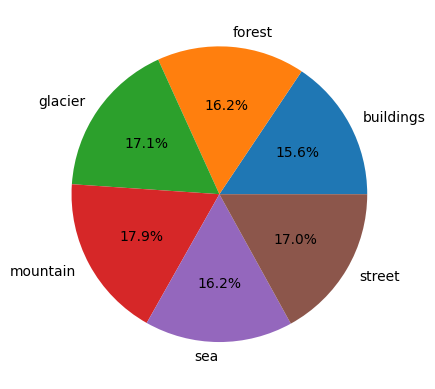

<AxesSubplot: >

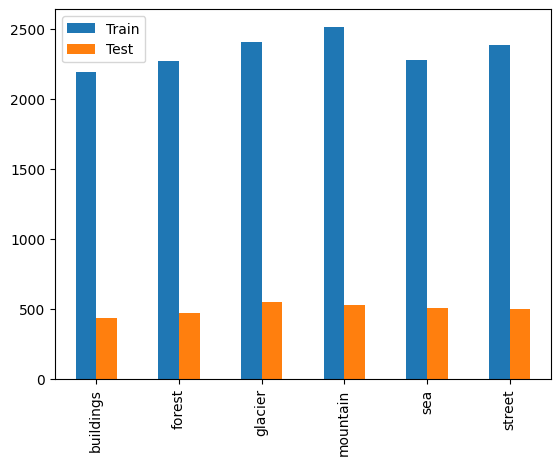

In [6]:
import matplotlib.pyplot as plt

_, train_count = np.unique(train_labels, return_counts=True)
_, test_count = np.unique(test_labels, return_counts=True)


plt.pie(train_count,
        explode=(0,0,0,0,0,0),
        labels=class_names,
        autopct='%1.1f%%')
plt.show()


df = pd.DataFrame({'Train': train_count,
              'Test': test_count},
              index=class_names,)

df.plot.bar()



As seen above, the images are labelled at a roughly equal distribution, meaning that we will have an equal amount of training to predict each category.

Next, let's see what kind of images we are working with. Below, we have created a function that will display the first 25 images of the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

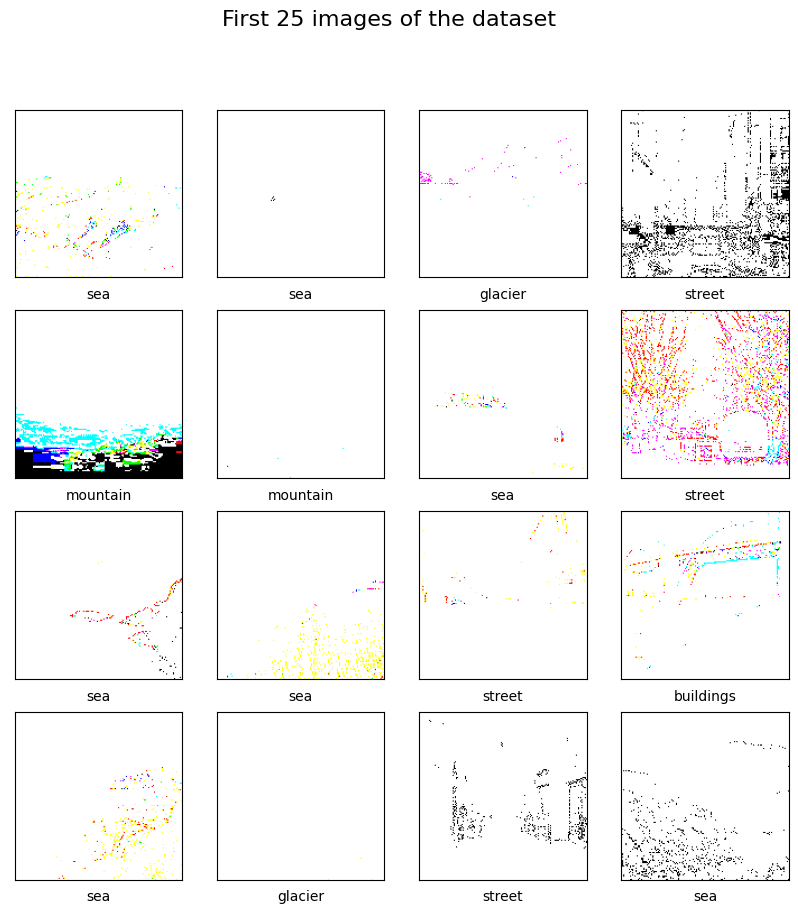

In [7]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("First 25 images of the dataset", fontsize=16)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

As we can see, the images are extremely distorted, oversaturated, and too bright. 

We now know that we must scale our data down to a visible color spectrum. We will redisplay the images after scaling down.

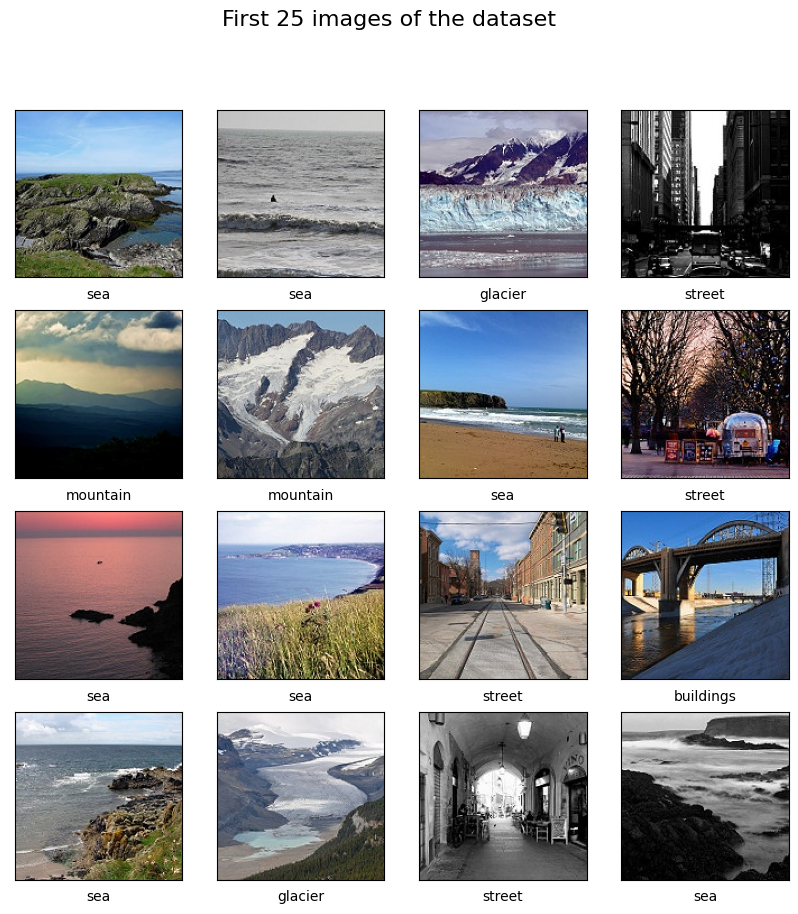

In [8]:
train_images = train_images / 255
test_images = test_images / 255

display_examples(class_names, train_images, train_labels)

# Sequential (CNN)

Now, we will create a model using Tensorflow's Keras class. 

There are several layers and components to the model such as:

- Conv2D: used for 'extracting' features from the image being evaluated
- MaxPooling2D: used to reduce the image size by half
- Flatten: transforms the image being read from a 2D-array to a 1D-array of pixel values
- Relu: an activation function that, given x, will return the max between x and 0
- Softmax: set to 6 neurons in our case, corresponding to one of the 6 unique labels we want as an output

We will use the 'adam' optimizer. 'Adam' is an optimization algorithm that combines the benefits of two algorithms:

- RMSProp: (Root Mean Square Propagation) exponentialy weights past gradients the further they are from the current layer
- Momentum: takes into account the past gradient and carries forward a small portion of the previous vector so that the optimizer keeps moving in relatively the same direction

We will also use a sparse categorical crossentropy loss function, since each image should only belong to one class.

In [9]:
CNN_model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation="softmax"),
    ]
)

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Let's output the layers and see the breakdown of our model's parameters.

In [13]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 128)               1

Now, we can fit our training data to our newly created model.

In [10]:
history = CNN_model.fit(train_images, train_labels,
                    batch_size=128,
                    epochs=25,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/25
88/88 [==============================] - 131s 1s/step - loss: 1.3745 - accuracy: 0.5139 - val_loss: 0.8200 - val_accuracy: 0.7111
Epoch 2/25
88/88 [==============================] - 130s 1s/step - loss: 0.7554 - accuracy: 0.7204 - val_loss: 0.7962 - val_accuracy: 0.7075
Epoch 3/25
88/88 [==============================] - 131s 1s/step - loss: 0.6201 - accuracy: 0.7746 - val_loss: 0.6929 - val_accuracy: 0.7556
Epoch 4/25
88/88 [==============================] - 132s 1s/step - loss: 0.4843 - accuracy: 0.8346 - val_loss: 0.6578 - val_accuracy: 0.7599
Epoch 5/25
88/88 [==============================] - 130s 1s/step - loss: 0.3541 - accuracy: 0.8804 - val_loss: 0.6595 - val_accuracy: 0.7859
Epoch 6/25
88/88 [==============================] - 130s 1s/step - loss: 0.2361 - accuracy: 0.9277 - val_loss: 0.7197 - val_accuracy: 0.7656
Epoch 7/25
88/88 [==============================] - 125s 1s/step - loss: 0.1648 - accuracy: 0.9523 - val_loss: 0.7240 - val_accuracy: 0.7912
Epoch 8/25
88

We can see that our model has reached a peak accuracy of 99%, but let's plot the model's accuracy history over time to further analyze.

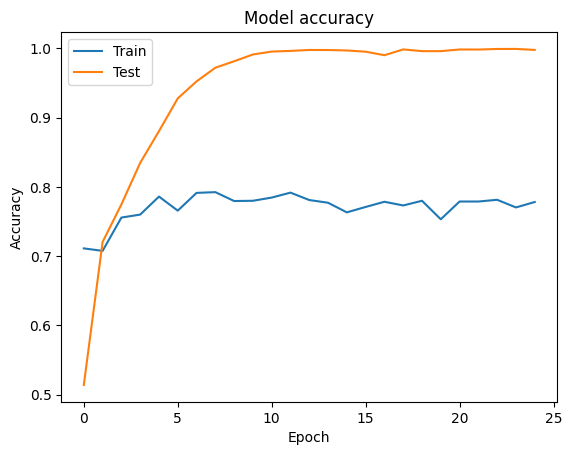

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

As shown above, the model's training accuracy seems to plateau very early, but our testing prediction accuracy continued to approach 100%. We believe that this may actually be a positive sign, since it appears that the model is generalizing the dataset better to the new data. The model does not seem like it is memorizing the training data, therefore we have determined that the model is not overfitting.